<h1><center>Plotting Ceria defect points equations</center></h1>

<h2>Imports and helper functions</h2>

In [5]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [6]:
#Contans
pi = np.pi
kb = 8.617333262145e-5  # Boltzmann constant in eV/K
T = 600 + 273.15        # Temperature in Kelvin

In [7]:
# Helper functions
def D_Coeff(D_0, E_m, T):
    return D_0 * np.exp(-E_m / (kb * T))

def log_factor(r_0, r_L, eps=1e-10):
    logt = np.log(8 * r_L / r_0)
    r = r_0 * logt
    return 1 / r 

def compute_j_L_v(C_Ce_v, C_O_v, D_Ce_v, D_O_v, r_0, r_L, eps=1e-10):
    log_fact = log_factor(r_0, r_L)
    num = D_Ce_v * C_Ce_v * D_O_v * C_O_v
    den = 2 * D_Ce_v * C_Ce_v + D_O_v * C_O_v
    return log_fact * num / den 

def compute_j_L_i(C_Ce_i, C_O_i, D_Ce_i, D_O_i, r_0, r_L, eps=1e-10):
    log_fact = log_factor(r_0, r_L)
    num = D_Ce_i * C_Ce_i * D_O_i * C_O_i
    den = 2 * D_Ce_i * C_Ce_i + D_O_i * C_O_i
    return log_fact * num / den 

def compute_j_ii(C_Ce_i, C_O_i, D_Ce_i, D_O_i, eps=1e-10):
    num = D_Ce_i * (C_Ce_i**2) * D_O_i * (C_O_i**2)
    den = 2 * D_Ce_i * (C_Ce_i**2) + D_O_i * (C_O_i**2)
    return num / den 

<h2>ODE System</h2>

In [8]:
# ODE system
def ODE_system(t, y, params):
    C_Ce_v, C_O_v, C_Ce_i, C_O_i, N_L, R_L = y

    G_VCe = params['G_Ce_v']
    G_VO  = params['G_O_v']
    G_CeI = params['G_Ce_i']
    G_OI  = params['G_O_i']
    a     = params['a']
    Omega_0 = (a**3) / 12
    D_Ce_i = params['D_Ce_i']
    D_O_i  = params['D_O_i']
    D_Ce_v = params['D_Ce_v']
    D_O_v  = params['D_O_v']
    r0     = params['r0']
    b = a / np.sqrt(3)

    j_L_v = compute_j_L_v(C_Ce_v, C_O_v, D_Ce_v, D_O_v, r0, R_L)
    j_L_i = compute_j_L_i(C_Ce_i, C_O_i, D_Ce_i, D_O_i, r0, R_L)
    j_ii  = compute_j_ii(C_Ce_i, C_O_i, D_Ce_i, D_O_i)

    k_ce = (Omega_0 / a**2) * (48 * D_Ce_i + 48 * D_Ce_i)
    k_o  = (Omega_0 / a**2) * (36 * D_O_i + 24 * D_O_i)

    beta = 84 * Omega_0 / a**2
    st   = 2 * pi * R_L * N_L

    if j_L_i - j_L_v <= 0:
        j_L_i = j_L_v = 0

    dc = np.zeros(6)
    
    dc[5] = 3 * Omega_0 * 2 * pi * r0 / b * (j_L_i - j_L_v) - R_L / (2 * N_L) * beta * j_ii
    
    if dc[5] < 0 and R_L < 2*r0:
        dc[5] = 0

    dc[0] = G_VCe - k_ce * C_Ce_v * C_Ce_i - j_L_v * pi * r0 * st
    dc[1] = G_VO  - k_o  * C_O_v  * C_O_i  - 2 * j_L_v * pi * r0 * st
    dc[2] = G_CeI - k_ce * C_Ce_i * C_Ce_v - j_L_i * pi * r0 * st - beta * j_ii
    dc[3] = G_OI  - k_o  * C_O_i  * C_O_v  - 2 * j_L_i * pi * r0 * st - 2 * beta * j_ii
    dc[4] = beta * j_ii

    return dc


<h2>Plotting Functions</h2>

In [9]:
def plotting_report(exp_data, results, G_0):
    time = results['time']
    dose = time * G_0
    exp_dose = exp_data['dose']

    fig = make_subplots(rows=2, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.08,
                        subplot_titles=("Loop Radius", "Loop Density"))

    fig.add_trace(go.Scatter(
        x=dose, y=results['R_L-LF']*1e7/2,  
        mode="lines", name="LF (600 °C)",
        line=dict(color="red", dash="dashdot")
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=dose, y=results['R_L-HF']*1e7/2,
        mode="lines", name="HF (600 °C)",
        line=dict(color="green")
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=[exp_dose], y=[exp_data['R_L (LF)']],
        mode="markers", marker=dict(symbol="square", color="red", size=12),
        error_y=dict(type="data", array=[exp_data['err R_L (LF)']]),
        name="Exp LF"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=[exp_dose], y=[exp_data['R_L (HF)']],
        mode="markers", marker=dict(symbol="diamond", color="green", size=12),
        error_y=dict(type="data", array=[exp_data['err R_L (HF)']]),
        name="Exp HF"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=dose, y=results['N_L-LF']*1e-16,
        mode="lines", name="LF (600 °C)",
        line=dict(color="red", dash="dashdot"),
        showlegend=False
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=dose, y=results['N_L-HF']*1e-16,
        mode="lines", name="HF (600 °C)",
        line=dict(color="green"),
        showlegend=False
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=[exp_dose], y=[exp_data['N_L (LF)']*1e-16],
        mode="markers", marker=dict(symbol="square", color="red", size=12),
        name="Exp LF", showlegend=False
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=[exp_dose], y=[exp_data['N_L (HF)']*1e-16],
        mode="markers", marker=dict(symbol="diamond", color="green", size=12),
        name="Exp HF", showlegend=False
    ), row=2, col=1)

    fig.update_xaxes(title_text="Dose [dpa]", row=2, col=1)
    fig.update_yaxes(title_text="Radius [nm]", row=1, col=1)
    fig.update_yaxes(title_text="Density [10<sup>16</sup> cm<sup>-3</sup>]", row=2, col=1)

    fig.update_layout(
        width=500, height=700,
        legend=dict(x=0.05, y=0.95, bgcolor="rgba(255,255,255,0.6)")
    )

    fig.write_image("../../images/Ceria-plot.svg")

    fig.show()
    return fig

<h3>Solving equations</h3>

In [10]:
#Parameters
a = 541e-10   # cm
N = 12 
Omega_0 = (a**3) / N
b = a / np.sqrt(3)

D_0_Ce_v, D_0_Ce_i, D_0_O_v, D_0_O_i = 0.65, 0.01, 0.02, 0.01
E_m_Ce_v, E_m_Ce_i, E_m_O_v, E_m_O_i = 5.3, 2.6, 0.836, 1.18

# Dose rate dpa/s
G_0 = 0.87e-6 #LF

ratio = 2
G_tot = G_0 / Omega_0
G_Ce = G_tot * (ratio / (1 + ratio))
G_O  = G_Ce   * (1 - ratio / (1 + ratio))

params = {
    'G_Ce_v': G_Ce, 'G_O_v': G_O,
    'G_Ce_i': G_Ce, 'G_O_i': G_O,
    'a': a, 
    'D_Ce_i': D_Coeff(D_0_Ce_i, E_m_Ce_i, T),
    'D_Ce_v': D_Coeff(D_0_Ce_v, E_m_Ce_v, T),
    'D_O_i':  D_Coeff(D_0_O_i,  E_m_O_i, T),
    'D_O_v':  D_Coeff(D_0_O_v,  E_m_O_v, T),
    'r0': 4*a,
}

In [11]:
# Initial conditions
t0 = 0.0001149
y0 = [G_Ce*t0, G_O*t0, G_Ce*t0, G_O*t0, G_O*t0*1e-6, np.sqrt(N*Omega_0/(pi*b))]

# Total time from total dose
dmg = 0.15   # dpa
t_end = dmg / G_0
t_span = (t0, t_end)
t_eval = np.linspace(t0, t_end, 1000)

solution_LF = solve_ivp(ODE_system, method='BDF', t_span=t_span, y0=y0,
                     args=(params,), t_eval=t_eval)


In [12]:

G_0 = 2.6e-6   #HF

ratio = 2
G_tot = G_0 / Omega_0
G_Ce = G_tot * (ratio / (1 + ratio))
G_O  = G_Ce   * (1 - ratio / (1 + ratio))

params['G_Ce_v'] = G_Ce
params['G_Ce_i'] = G_Ce
params['G_O_v'] = G_O
params['G_O_i'] = G_O

solution_HF = solve_ivp(ODE_system, method='BDF', t_span=t_span, y0=y0,
                     args=(params,), t_eval=t_eval)


In [13]:
# Put LF results in a DataFrame
results = pd.DataFrame({
    'time': solution_LF.t,
    'dose': solution_LF.t * G_0,
    'C_Ce_v-LF': solution_LF.y[0],
    'C_O_v-LF':  solution_LF.y[1],
    'C_Ce_i-LF': solution_LF.y[2],
    'C_O_i-LF':  solution_LF.y[3],
    'N_L-LF':    solution_LF.y[4],
    'R_L-LF':    solution_LF.y[5],
    'C_Ce_v-HF': solution_HF.y[0],
    'C_O_v-HF':  solution_HF.y[1],
    'C_Ce_i-HF': solution_HF.y[2],
    'C_O_i-HF':  solution_HF.y[3],
    'N_L-HF':    solution_HF.y[4],
    'R_L-HF':    solution_HF.y[5],
})

# Experimental data
exp_data = {
    'dose': 0.14,
    'R_L (LF)': 1.79,  'err R_L (LF)': 0.49,
    'R_L (HF)': 2.00,  'err R_L (HF)': 0.51,
    'N_L (LF)': 6.5e16,'N_L (HF)': 11.8e16,
}



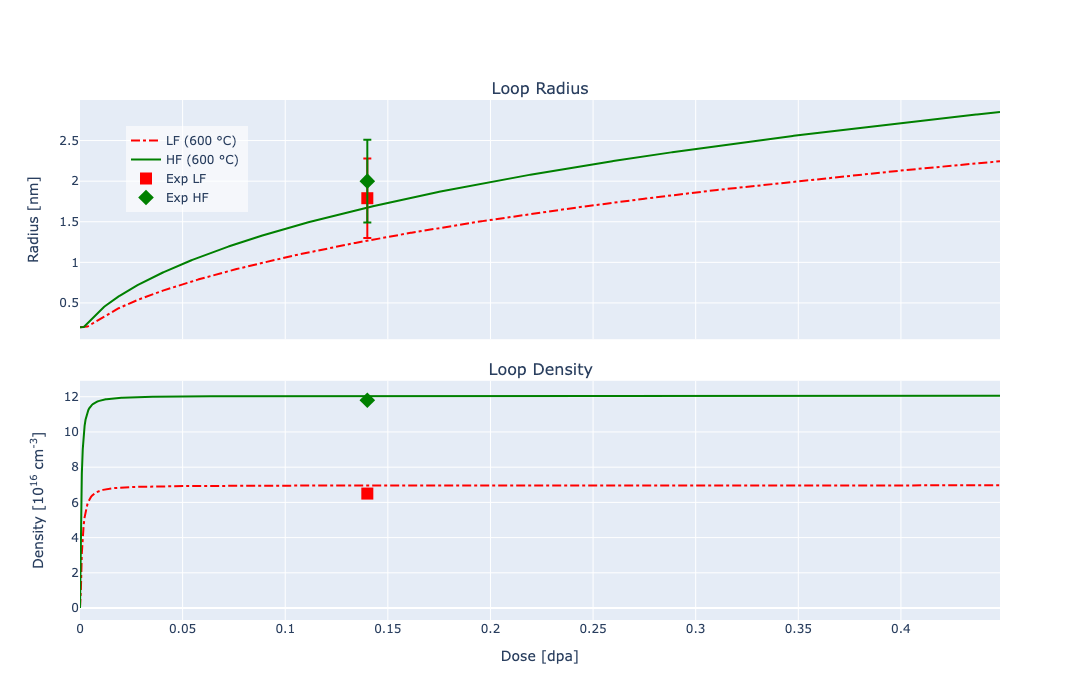

In [14]:
fig = plotting_report(exp_data, results, G_0)

